## Statistical Arbitrage Event-Based Backtest
#### Stocks used:
* PEP
* KO

In [124]:
list = ['PEP', 'KO']

In [125]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [126]:
class Common_Class():

  def __init__(self, symbols, start, end, interval, capital, transcation_cost, verbose = True):
    self.symbols = symbols
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital  # initial capital
    self.capital = {symbol: capital / len(symbols) for symbol in symbols} # capital change throughout trades made
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = {symbol: 0 for symbol in symbols} # quantities to buy/sell
    self.position = {symbol: 0 for symbol in symbols} # the trades in progress, long or short
    self.trades = {symbol: 0 for symbol in symbols} # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = {symbol: pd.DataFrame(columns=['trade', 'date', 'position', 'price', 
                          'symbol', 'quantity', 'capital']) 
                            for symbol in symbols} # to store trade details
    self.prepare_data() # prepares the data

  def prepare_data(self):
    self.data = {}
    for symbol in self.symbols:
      stock_data = yf.Ticker(symbol)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.data[symbol] = bt_data
  
  def check_suitability(self):
    prices = pd.DataFrame()
    returns = pd.DataFrame()
    for symbol in self.symbols:
      prices[f'{symbol}'] = self.data[symbol]['Close_Price']
      returns[f'{symbol}'] = self.data[symbol]['Return']

    correlation = returns.corr().iloc[0, 1]
    print(f"Correlation between {self.symbols[0]} and {self.symbols[1]}: {correlation}")

    score, p_value, _ = coint(prices[f'{self.symbols[0]}'], prices[f'{self.symbols[1]}'])

    print(f"Cointegration p-value {self.symbols[0]} and {self.symbols[1]}: {p_value}")

  def close_graph(self):
    plt.figure(figsize=(15, 5))
    for symbol in self.symbols:
      plt.plot(self.data[symbol]["Close_Price"], label=symbol, linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of All Stocks")
    plt.legend()
    plt.grid()
    plt.show()

  # A bar is a unit of data at a given time, depends on the interval chosen, it provides the OHLCV and time info
  # Since we have modeled close prices, we will get the price and date
  def return_date_price(self, bar, symbol):
    date = str(self.data[symbol].index[bar])[:10]
    price = self.data[symbol].Close_Price.iloc[bar]
    return date, price
  
  # Returns the realised capital in account at a given time period / bar
  def realised_balance(self, bar):
    total = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      total += self.capital[symbol]
    print("Date :{} | Realised Balance: {:0.1f}".format(date, total))

  # Returns the unrealised capital (trades in progress) in account at a given time period / bar
  def unrealised_balance(self, bar):
    total_ub = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      total_ub += self.quantity[symbol] * price
    print("Date :{} | Unrealised Balance: {:0.1f}".format(date, total_ub))

  # Unrealised plus realised balance (total)
  def total_balance(self, bar):
    tb = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      tb += self.quantity[symbol] *price + self.capital[symbol]
    print("Date :{} | Total Balance: {:0.1f}".format(date, tb))

  # Store results of the trade
  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data[symbol] = pd.concat([self.stored_data[symbol], trade_detail])


  def performance(self):
    final_df = pd.DataFrame()
    for symbol in self.symbols:
      B = self.stored_data[symbol]
      B.index = range(B.shape[0]) 

      #Preparing metrics to calculate performance
      B['exit_date'] = B['date'].shift(-1)
      B['exit_price'] = B['price'].shift(-1)
      B['capital_after_settlement'] = B['capital'].shift(-1)
      final_df = pd.concat([final_df, B], ignore_index=True)

    final_df = final_df.drop_duplicates(subset=['symbol', 'date'], keep='last').reset_index(drop=True)
    grouped_df = final_df.groupby(['exit_date'])['capital_after_settlement'].sum().reset_index()
    final_df.drop(columns=['capital_after_settlement'], inplace=True)
    final_df = final_df.merge(grouped_df, on='exit_date')
    final_df.sort_values(by='exit_date', inplace=True)

    # Calculate returns based on changes in capital
    Final_result_data = final_df.drop_duplicates(subset='exit_date', keep='last').reset_index(drop=True)
    Final_result_data['capital_regular_returns'] = (Final_result_data['capital_after_settlement']/Final_result_data['capital_after_settlement'].shift(1) - 1)
    Final_result_data['capital_log_returns'] = np.log(Final_result_data['capital_after_settlement']/Final_result_data['capital_after_settlement'].shift(1))
    Final_result_data["capital_returns_log_cum_sum"] = Final_result_data["capital_log_returns"].cumsum()
    Final_result_data.drop(Final_result_data.index[Final_result_data['capital_log_returns'] == 0.0], inplace=True)
    Final_result_data = Final_result_data.dropna()

    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price','capital','capital_after_settlement', 'capital_regular_returns', 'capital_log_returns', 'capital_returns_log_cum_sum']
    Final_result_data = Final_result_data[cols]
    Final_result_data.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    # Plot equity curve
    plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns are {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation  is {:0.2f} %".format(annual_regular_std))

    # Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio is {:0.2f}".format(SR))

    # Calclate returns on investment in percent
    Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    Total_Log_ret
    Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, Regular_ROI))

    # Calculate maximum drawdown
    Final_result_data['cumulative_capital_returns'] = Final_result_data['capital_log_returns'].cumsum().apply(np.exp)
    Final_result_data['maximum_returns'] = Final_result_data['cumulative_capital_returns'].cummax()
    Final_result_data['max_drawdown'] = Final_result_data['maximum_returns'] - Final_result_data['cumulative_capital_returns']
    max_drawdown = Final_result_data['max_drawdown'].max()

    plt.figure(figsize=(12, 6))
    plt.plot(Final_result_data['exit_date'], Final_result_data['cumulative_capital_returns'], label='Cumulative Returns')
    plt.plot(Final_result_data['exit_date'], Final_result_data['maximum_returns'], label='Maximum Returns')
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Capital Returns and Maximum Returns")
    plt.legend()
    plt.show()

    print("The maximum drawdown is {:0.2f}".format(max_drawdown))

    calmar_ratio = (annual_regular_return/ 100) / max_drawdown
    print("The calmar ratio is {:0.2f}".format(calmar_ratio))


  def buy_order(self,bar, symbol, quantity=None, dollar =None, ):
    date, price = self.return_date_price(bar, symbol)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[symbol] = self.capital[symbol] - ((quantity * price)*(1 + self.transaction_cost)) 
    self.quantity[symbol] = self.quantity[symbol] + quantity
    self.trades[symbol] = self.trades[symbol] + 1
    self.position[symbol] = 1 
    self.store_results(self.trades[symbol], date, self.position[symbol], price, symbol, quantity, self.quantity[symbol]*price + self.capital[symbol])

    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)


  def sell_order(self,bar, symbol, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, symbol)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[symbol] = self.capital[symbol] + ((quantity * price)*(1 - self.transaction_cost)) 
    self.quantity[symbol] = self.quantity[symbol] - quantity
    self.trades[symbol] = self.trades[symbol] + 1
    self.position[symbol] = -1
    self.store_results(self.trades[symbol], date, self.position[symbol], price, symbol, quantity, self.quantity[symbol]*price + self.capital[symbol])

    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity, symbol, price, quantity * price))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  def last_trade(self, bar):
    current_capital = 0
    total_trades = 0
    for symbol in self.symbols:
      date, price = self.return_date_price(bar, symbol)
      last_quantity = self.quantity[symbol]
      self.capital[symbol] = self.capital[symbol] + last_quantity * price
      self.quantity[symbol] = 0 
      self.trades[symbol] = self.trades[symbol] +1
      if self.position[symbol] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records
        self.position[symbol] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve number in records
        self.position[symbol] = -1 # to record we are selling to close out

      self.store_results(self.trades[symbol], date, self.position[symbol], price, symbol, last_quantity, self.quantity[symbol]*price + self.capital[symbol])
      current_capital += self.capital[symbol]
      total_trades += self.capital[symbol]

    print("=" *50)
    print("--------------Final Balance-----------")
    self.total_balance(bar)
    print("=" *50)

    if self.verbose:
      print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity, symbol, price, last_quantity * price))
      print("--------------Final Balance-----------")
      self.total_balance(bar)
      
      returns = (current_capital - self.initial_capital) /self.initial_capital * 100
      print("------------------------------")
      print("The total capital at end of strategy: {:0.1f}".format(current_capital))
      print( "The strategy returns on investment are {:0.1f} %".format(returns))
      print( "Total trades by startegy are {:0.1f}".format(total_trades))


In [127]:
class Strategy(Common_Class):

  def go_long(self, bar, symbol, quantity = None, dollar = None): 
    if self.position[symbol] == -1: # Clear previous position
      self.position[symbol] = 0
      self.buy_order(bar, symbol, quantity = -self.quantity[symbol]) # negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order(bar, symbol, quantity = quantity) # to create new order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[symbol]
      self.buy_order(bar, symbol, dollar = dollar)

  def go_short(self, bar, symbol, quantity = None, dollar = None):
    if self.position[symbol] == 1: # Clear previous position
      self.position[symbol] = 0
      self.sell_order(bar, symbol, quantity = self.quantity[symbol]) 
    if quantity:
      self.sell_order (bar, symbol, quantity = quantity) # to create new order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[symbol]
      self.sell_order(bar, symbol, dollar = dollar)

  def run_strategy(self, window): 
    pairs_df = pd.DataFrame()
    pairs_df['Difference_of_Returns'] = self.data[self.symbols[0]]['Return'] - self.data[self.symbols[1]]['Return']
    pairs_df['Difference_of_Returns_Mean14'] = pairs_df['Difference_of_Returns'].rolling(window).mean()
    pairs_df['Difference_of_Returns_SD14'] = pairs_df['Difference_of_Returns'].rolling(window).std()
    pairs_df['Z_Score_Returns'] = (pairs_df['Difference_of_Returns'] - pairs_df['Difference_of_Returns_Mean14']) / pairs_df['Difference_of_Returns_SD14']

    for bar in range(window, len(pairs_df)): 
      date, price0 = self.return_date_price(bar, self.symbols[0])
      date, price1 = self.return_date_price(bar, self.symbols[1])

      z_score = pairs_df['Z_Score_Returns'].iloc[bar]

      # If Z-score < -1: Go long on symbol[0] (undervalued) and short on symbol[1]
      if self.position[self.symbols[0]] in [0, -1] and z_score < -1:
        self.go_long(bar, self.symbols[0], dollar=5000)   # Go long symbol[0]
        self.go_short(bar, self.symbols[1], dollar=5000)  # Go short symbol[1]
        continue  # Move to the next iteration

      # If Z-score > 1: Go short on symbol[0] (overvalued) and long on symbol[1]
      if self.position[self.symbols[0]] in [0, 1] and z_score > 1:
        self.go_short(bar, self.symbols[0], dollar=5000)  # Go short symbol[0]
        self.go_long(bar, self.symbols[1], dollar=5000)   # Go long symbol[1]
        continue

      # Store all the values for calculating Sharpe
      store_quantity = abs(self.quantity[self.symbols[0]]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
      self.store_results(0, date, self.position[self.symbols[0]], price0, self.symbols[0], store_quantity, self.quantity[self.symbols[0]] * price0 + self.capital[self.symbols[0]])

      store_quantity = abs(self.quantity[self.symbols[1]]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on self.position sign
      self.store_results(0, date, self.position[self.symbols[1]], price1, self.symbols[1], store_quantity, self.quantity[self.symbols[1]] * price1 + self.capital[self.symbols[1]])

    print("=" * 50)
    print("End of last bar")
    print("=" * 50)
    self.last_trade(bar)  
    for symbol in self.symbols:
      print(self.stored_data[symbol])

Correlation between PEP and KO: 0.7798698394593536
Cointegration p-value PEP and KO: 0.1336188502687239


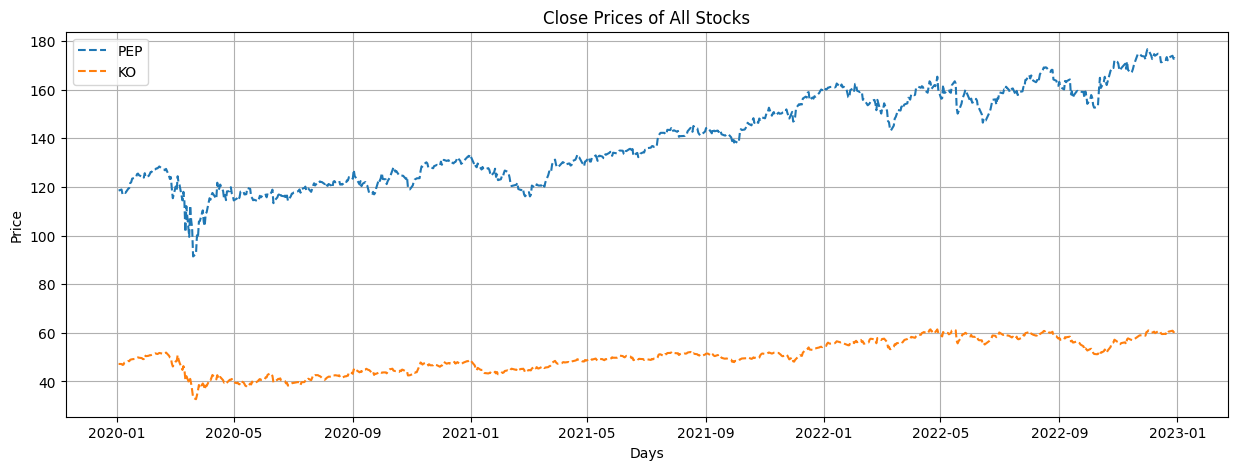

C:\Users\chuac\AppData\Local\Temp\ipykernel_38908\2509267310.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data[symbol] = pd.concat([self.stored_data[symbol], trade_detail])


End of last bar
--------------Final Balance-----------
Date :2022-12-30 | Total Balance: 22959.9
   trade        date position       price symbol quantity       capital
0      0  2020-01-24        0  124.837547    PEP        0  10000.000000
0      0  2020-01-27        0  124.156227    PEP        0  10000.000000
0      1  2020-01-28       -1  124.418282    PEP       40  10000.000000
0      0  2020-01-29       -1  123.798088    PEP       40  10024.807739
0      2  2020-01-30        1  125.632401    PEP       40   9951.435242
..   ...         ...      ...         ...    ...      ...           ...
0      0  2022-12-27        1  173.907486    PEP       28  17611.653412
0      0  2022-12-28        1  172.653534    PEP       28  17576.542755
0      0  2022-12-29        1  172.872009    PEP       28  17582.660065
0      0  2022-12-30        1  171.618088    PEP       28  17547.550262
0    244  2022-12-30       -1  171.618088    PEP       28  17547.550262

[863 rows x 7 columns]
   trade       

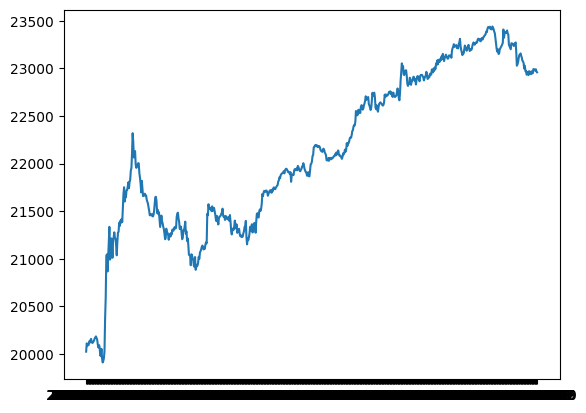

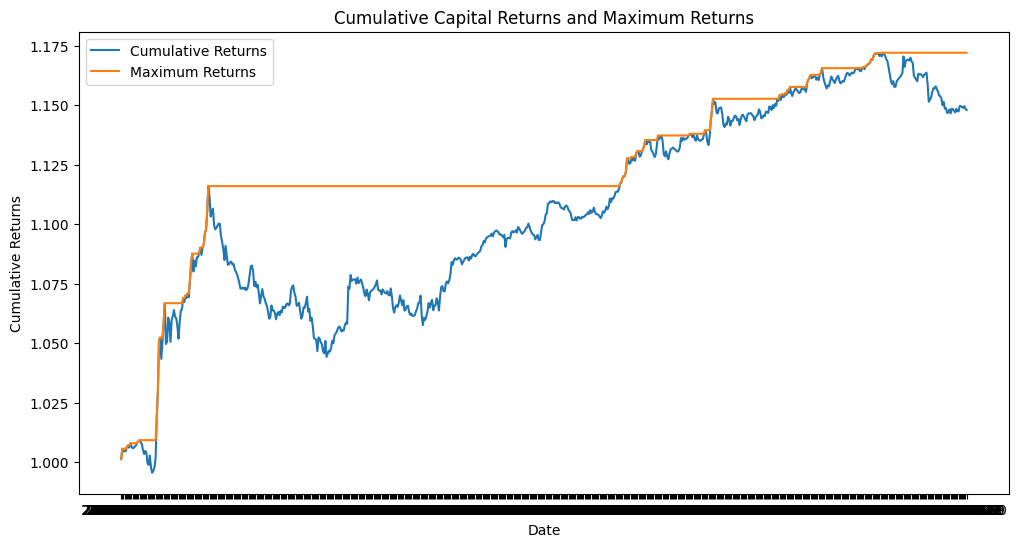

The maximum drawdown is 0.07
The calmar ratio is 0.67


In [128]:
if __name__ == "__main__":
  strat = Strategy(list, "2020-01-01", "2023-01-01","1d", 20000, 0.0, False)
  strat.check_suitability()
  strat.close_graph()
  strat.run_strategy(14)
  strat.performance()